# 1. Cartpole System Evaluation

In [2]:
import gym
import tensorflow as tf
import numpy as np
import pickle

import control
from scipy.linalg import lu
import math
import cmath

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model = tf.keras.models.load_model(
    './cartpole_system_model', custom_objects=None, compile=True, options=None
)

2022-04-10 16:26:46.324995: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
np_weights = model.get_weights()
print(model.A.get_weights())
print(model.B.get_weights())

[array([[ 1.0000035e+00, -1.2942681e-05, -2.3801964e-05,  1.6305943e-03],
       [ 2.0008639e-02,  9.9992085e-01, -2.6311722e-05, -9.5092575e-04],
       [-8.2056704e-07, -1.3424688e-02,  1.0000260e+00,  3.1254122e-01],
       [-4.4493249e-06, -5.0352475e-05,  2.0024499e-02,  9.9951327e-01]],
      dtype=float32)]
[array([[ 6.6651064e-06,  1.9508155e-01, -1.1186228e-05, -2.9142728e-01]],
      dtype=float32)]


In [5]:
A = np_weights[0]
B = np_weights[1].T
print("A Matrix")
print(A)
print("B Matrix")
print(B)

A Matrix
[[ 1.0000035e+00 -1.2942681e-05 -2.3801964e-05  1.6305943e-03]
 [ 2.0008639e-02  9.9992085e-01 -2.6311722e-05 -9.5092575e-04]
 [-8.2056704e-07 -1.3424688e-02  1.0000260e+00  3.1254122e-01]
 [-4.4493249e-06 -5.0352475e-05  2.0024499e-02  9.9951327e-01]]
B Matrix
[[ 6.6651064e-06]
 [ 1.9508155e-01]
 [-1.1186228e-05]
 [-2.9142728e-01]]


## Controllability

In [6]:
# controllability matrix
C_matrix = control.ctrb(A, B)

# obtain rank via LU decomposition
_, L_matrix, U_matrix = lu(C_matrix, permute_l = False)

print(L_matrix)
print(U_matrix)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.83842859e-05  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.69400421e-01 -3.73572422e-03  1.00000000e+00  0.00000000e+00]
 [-2.28705642e-05  5.09830605e-03 -1.75525639e-03  1.00000000e+00]]
[[-2.91427284e-01 -2.91295484e-01 -2.93040094e-01 -2.96659494e-01]
 [ 0.00000000e+00 -9.37019523e-02 -1.87368589e-01 -2.81586268e-01]
 [ 0.00000000e+00  0.00000000e+00 -1.26317676e-03 -3.78880392e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.96584977e-08]]


The controllability matrix is fully-ranked column-wise.

## Controllability Gramian

In [7]:
# gramian can be derived from the controllability matrix
W_c = np.matmul(C_matrix, C_matrix.T)
print(W_c)

lambda_wc, xi_wc = np.linalg.eig(W_c)
for i in range(len(lambda_wc)):
    print("Eigenvalue: ", i)
    print(lambda_wc[i])
    print("Eigenvector")
    print(xi_wc[i])

[[ 3.14029469e-06 -5.54363903e-04  6.21971564e-04  8.34514749e-04]
 [-5.54363903e-04  1.52830488e-01 -1.10109620e-01 -2.29172671e-01]
 [ 6.21971564e-04 -1.10109620e-01  1.23190594e-01  1.65749896e-01]
 [ 8.34514749e-04 -2.29172671e-01  1.65749896e-01  3.43662274e-01]]
Eigenvalue:  0
0.5826697169407788
Eigenvector
[0.00200205 0.00466293 0.99998485 0.00213298]
Eigenvalue:  1
0.03701567940873113
Eigenvector
[-0.50891785  0.22773799  0.00172766 -0.83014158]
Eigenvalue:  2
2.4474805252676195e-16
Eigenvector
[ 0.39741134  0.91759083 -0.00509163  0.00808509]
Eigenvalue:  3
1.0999789443842272e-06
Eigenvector
[ 0.76358552 -0.32579247  0.00117955 -0.55748994]


Looking at the eigenvalues of the controllable gramian, we can see that, as expected, the pole's angle and angular velocities are less controllable compared to the cart's position and velocity.

In [11]:
def gramian_2d_ellipse(eig_x, eig_y, eig_vec_x, eig_vec_y):    
    # measure eigenvector sizes projected onto xy-plane
    proj_eig_vec_unit_len = np.sqrt(eig_vec_x ** 2 + eig_vec_y ** 2)
    width = eig_x * proj_eig_vec_unit_len
    height = eig_y * proj_eig_vec_unit_len
    
    # parameterized ellipse function
    t = np.linspace(0, 2 * math.pi, 100)
    gramian = np.array([eig_x * np.cos(t), eig_y * np.sin(t)])
    gramian_angle = np.angle(complex(eig_vec_x, eig_vec_y))
    gramian_rotation = np.array([
        [np.cos(gramian_angle), - np.sin(gramian_angle)],
        [np.sin(gramian_angle), np.cos(gramian_angle)],
        ])
    gramian = np.matmul(gramian_rotation, gramian)
    return gramian

### Cart Position and Velocity

In [12]:
cart_gramian_ellipse = gramian_2d_ellipse(lambda_wc[0], lambda_wc[1], xi_wc[0][0], xi_wc[0][1])

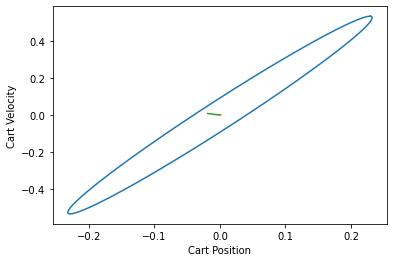

In [13]:
plt.plot(cart_gramian_ellipse[0], cart_gramian_ellipse[1])
eigen_width = lambda_wc[0] * xi_wc[0]
eigen_height = lambda_wc[1] * xi_wc[1]
plt.plot([0, eigen_width[0]], [0, eigen_width[1]])
plt.plot([0, eigen_height[0]], [0, eigen_height[1]])
plt.xlabel("Cart Position")
plt.ylabel("Cart Velocity")
plt.show()

### Pole Angle and Angular Velocity

In [10]:
pole_gramian_ellipse = gramian_2d_ellipse(lambda_wc[2], lambda_wc[3], xi_wc[2][0], xi_wc[2][1])

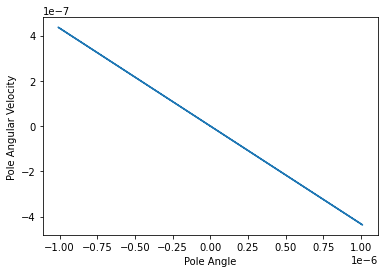

In [11]:
plt.plot(pole_gramian_ellipse[0], pole_gramian_ellipse[1])
plt.xlabel("Pole Angle")
plt.ylabel("Pole Angular Velocity")
plt.show()